In [1]:
import os
os.environ['R_HOME'] = os.getenv("CONDA_PREFIX")+"/envs/muscle/lib/R/"
import scanpy as sc
import numpy as np
import pandas as pd
import proportion_test
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import anndata2ri
sc.set_figure_params()
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = ["sans-serif"]
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.bbox"] = "tight"
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

In [2]:
adata_bulk=sc.read("adata_bulk_star.h5ad")

In [3]:
adata_bulk.obs["time"]=[n[:2] for n in adata_bulk.obs_names]
adata_bulk.obs["exp"]=[n[-1] for n in adata_bulk.obs_names]
adata_bulk.obs["condition"]=[n[2] for n in adata_bulk.obs_names]

In [4]:
adata_bulk.obs.condition=adata_bulk.obs.condition.replace(["H","S"],["hard","soft"])

In [5]:
adata_bulk.obs_names=["_".join([t,c,"ex"+e]) for t,c,e in zip(adata_bulk.obs.time,adata_bulk.obs.condition,adata_bulk.obs.exp)]

In [6]:
import deseq2py as deseq2

In [7]:
sc.pp.filter_genes(adata_bulk,min_cells=2)

In [8]:
deseq2.tl.run(adata_bulk,formula="~ exp + condition + time")

Running DESeq2
    done (0:00:18) --> added
    .layers['normalized'] normalized count matrix.
    .uns['dds'] DESeq2 R object.
    .uns['Formula'] formula used for design parameter.


In [9]:
deseq2.tl.vst(adata_bulk)

Obtaining vsd
    done (0:00:02) --> added
    .layers['vsd'] variance stabilized count matrix.


In [10]:
deseq2.tl.pca(adata_bulk)

Obtaining PCA
    on highly variable genes using vsd matrix
    done (0:00:00) --> added
    .var['vsd_std'] variance of genes calculated from vsd matrix.
    .var['highly_variable'] genes considered as highly variable.
    .obsm['X_pca'] PCA results.
    .uns['pca'] PCA additional results.


/home/lfaure/miniconda3/envs/muscle/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


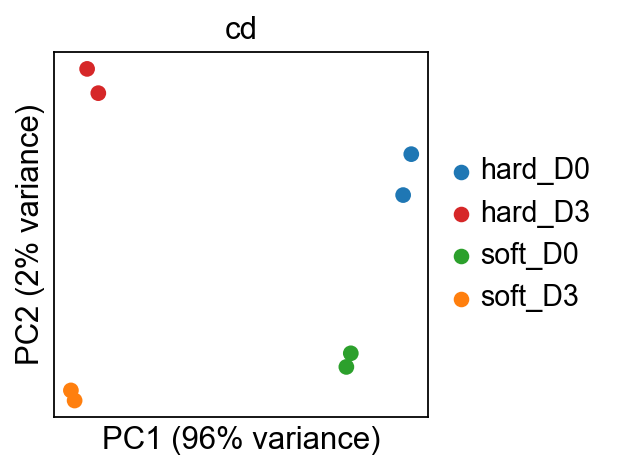

In [11]:
adata_bulk.obs["cd"]=adata_bulk.obs.condition.astype(str)+"_"+adata_bulk.obs.time.astype(str)
sc.set_figure_params(figsize=(3,3),dpi_save=300)
deseq2.pl.pca(adata_bulk,color=["cd"],palette=["tab:blue","tab:red","tab:green","tab:orange"])

In [12]:
deseq2.tl.result(adata_bulk,lfc_shrink=True,name="time_D3_vs_D0")

Generating DE results
    running LFC shrinking
    done (0:00:15) --> added
    .uns['time_D3_vs_D0']['LFC_shrink'] table of differential expression results.


In [13]:
deseq2.tl.result(adata_bulk,lfc_shrink=True,name="condition_soft_vs_hard")

Generating DE results
    running LFC shrinking
    done (0:00:14) --> added
    .uns['condition_soft_vs_hard']['LFC_shrink'] table of differential expression results.


In [14]:
DE_res = adata_bulk.uns["condition_soft_vs_hard"]["LFC_shrink"]

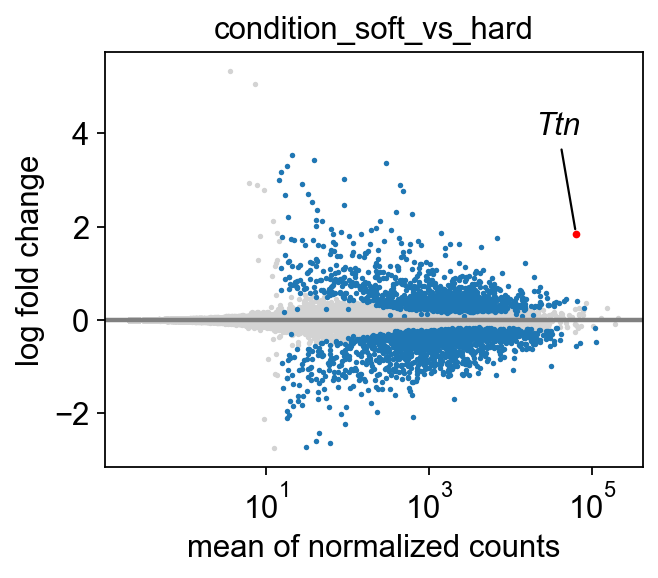

In [15]:
ax=deseq2.pl.result(adata_bulk,"LFC_shrink","condition_soft_vs_hard",show=False)
ax.annotate("Ttn",(DE_res.loc["Ttn","baseMean"],
            DE_res.loc["Ttn","log2FoldChange"]),
            xytext=(0.8, 0.8), textcoords='axes fraction',fontstyle="italic",
            arrowprops=dict(facecolor='black',arrowstyle="-"));
ax.scatter(DE_res.loc["Ttn","baseMean"],
            DE_res.loc["Ttn","log2FoldChange"],s=6,c="red");
plt.savefig("DE_res_conditions.pdf")

In [16]:
deseq2.tl.save(adata_bulk,"bulk_deseq2")

Saving results
    done --> saved
    bulk_deseq2.h5ad: anndata file containing counts matrices, pca and DE results.
    bulk_deseq2.rds: R object of the DESeqDataSet.


## DESeq2 result comparison

### Time DE scoring

In [17]:
df=adata_bulk.uns["time_D3_vs_D0"]["LFC_shrink"].sort_values("padj")

In [18]:
df

,baseMean,log2FoldChange,lfcSE,pvalue,padj
Geneid,,,,,
Hmga1,2575.371680,-3.202165,0.084605,0.000000e+00,0.000000e+00
Hmga2,5758.789266,-3.212156,0.086235,7.825899e-305,7.900245e-301
Tmem38a,5350.519301,4.845951,0.136163,1.320294e-280,8.885577e-277
Mef2c,3366.249107,4.458277,0.126587,2.667153e-274,1.346246e-270
Myl4,15590.081281,8.282090,0.244536,2.583661e-262,1.043282e-258
...,...,...,...,...,...
Gm20775,0.339705,-0.085972,0.833200,6.947165e-01,NaN
Gapdh-ps15,0.266208,0.080331,0.831578,6.692422e-01,NaN
Gm21860,0.469446,-0.027765,0.821998,8.275131e-01,NaN


In [61]:
%%R -o adata
load("../scRNAseq/adata_combined.RData")

In [66]:
adata.X=adata.layers["logcounts"]

In [67]:
d3=df.loc[df.log2FoldChange>0].index[:10]
d0=df.loc[df.log2FoldChange<0].index[:10]

In [68]:
adata.obs["condition"]=[n.split("_")[0] for n in adata.obs_names]
adata_nc=adata.copy()
sc.pp.scale(adata,max_value=5)
sc.tl.score_genes(adata,d3,score_name="D3")
sc.tl.score_genes(adata,d0,score_name="D0")

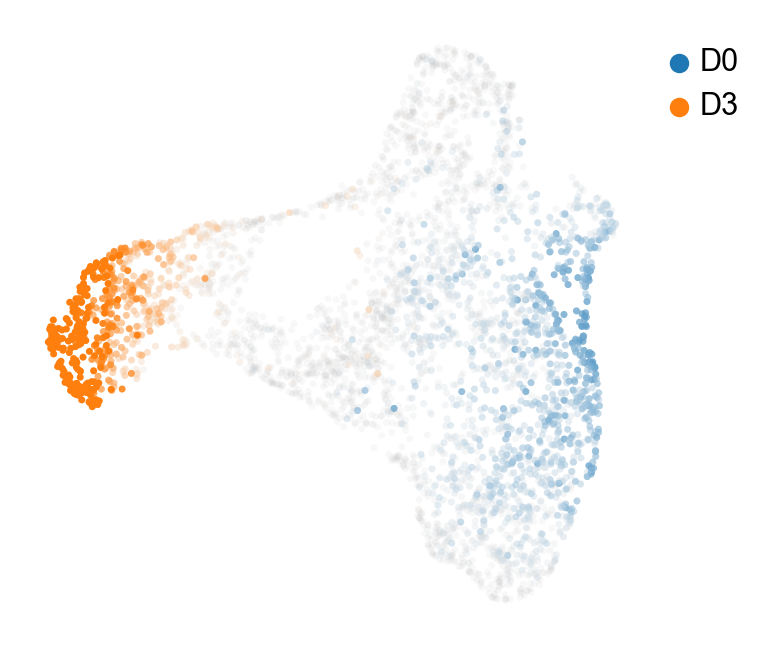

In [69]:
import scvelo as scv
scv.set_figure_params(figsize=(4,4))
scv.pl.umap(adata,color_gradients=["D0","D3"],perc=[1,95])

In [70]:
adata_hard=sc.read("../scRNAseq/adata_hard.h5ad")
adata_soft=sc.read("../scRNAseq/adata_soft.h5ad")

In [71]:
adata.obs["latent_time"]=0
adata.obs.loc[adata_hard.obs_names,"latent_time"]=adata_hard.obs["latent_time"]
adata.obs.loc[adata_soft.obs_names,"latent_time"]=adata_soft.obs["latent_time"]

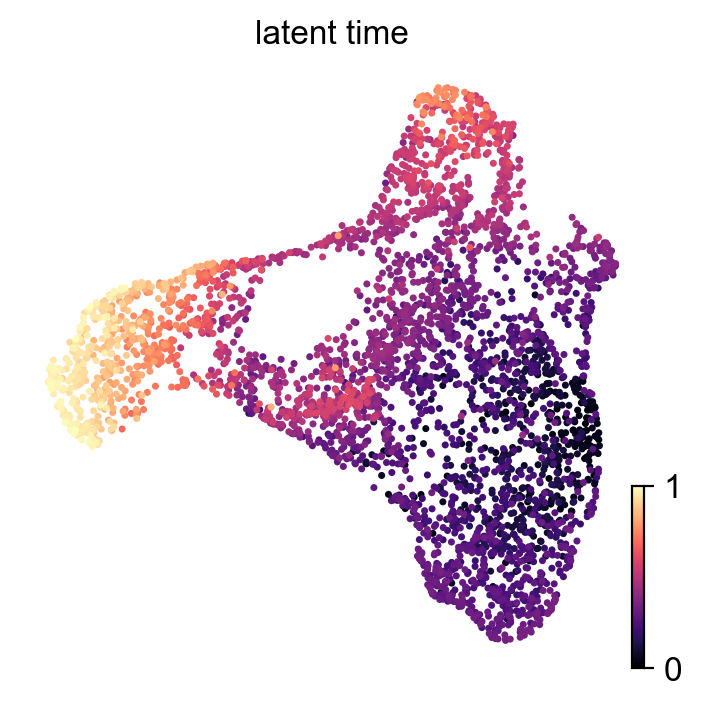

In [72]:
scv.pl.umap(adata,color="latent_time",cmap="magma")

In [73]:
adata_hard.obs["D3 score"]=adata.obs.D3[adata_hard.obs_names].values
adata_hard.obs["D0 score"]=adata.obs.D0[adata_hard.obs_names].values

In [74]:
adata.uns["leiden_colors"]=adata_hard.uns["clusters_colors"]

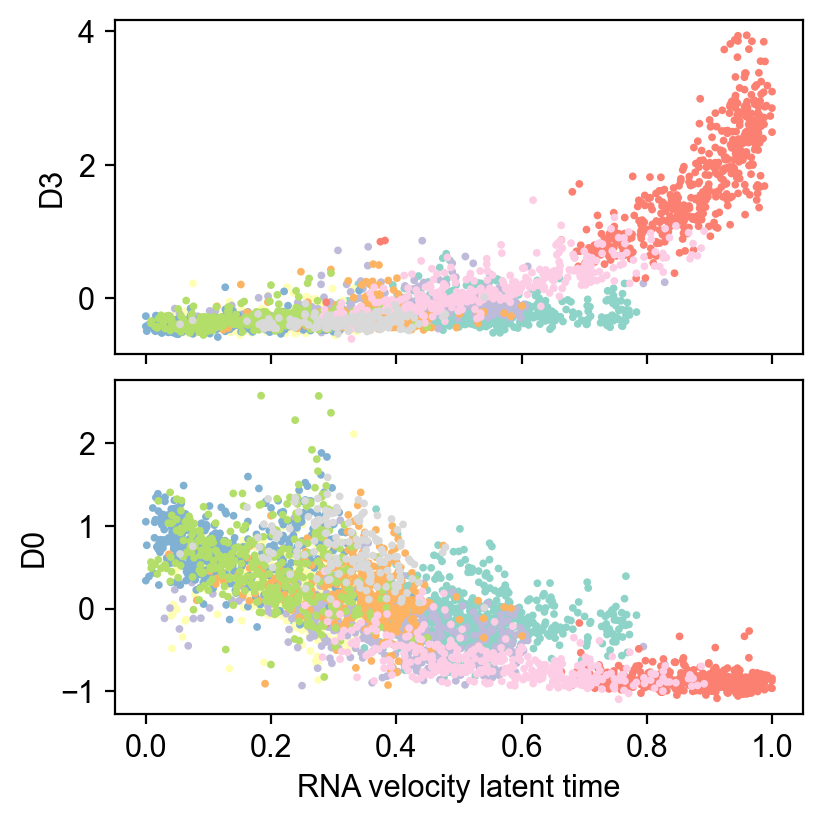

In [75]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,constrained_layout=True)
sc.pl.scatter(adata,x="latent_time",y="D3",color="leiden",ax=ax1,show=False,title="",legend_loc="none")
sc.pl.scatter(adata,x="latent_time",y="D0",color="leiden",ax=ax2,show=False,title="",legend_loc="none")
ax1.set_xlabel(None);
ax2.set_xlabel("RNA velocity latent time");
plt.savefig("D0D3_scoring_latenttime.pdf")

## RNA-sieve

In [76]:
%%R -o adata
load("../scRNAseq/adata_combined.RData")

In [77]:
adata.obs["condition"]=[n.split("_")[0] for n in adata.obs_names]

In [78]:
common=np.intersect1d(adata_bulk.var_names,adata.var_names)

adata=adata[:,common]
adata_bulk=adata_bulk[:,common]

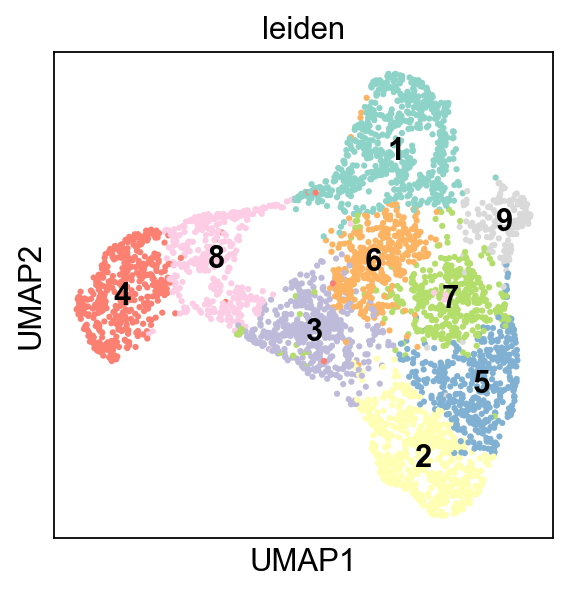

In [79]:
sc.set_figure_params()
adata.uns["leiden_colors"]=adata_hard.uns["clusters_colors"]
sc.pl.umap(adata,color="leiden",legend_loc="on data")

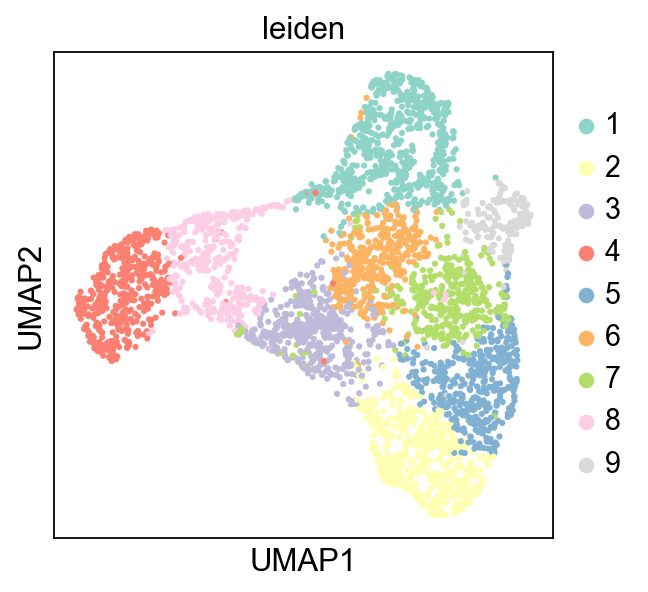

In [80]:
sc.pl.umap(adata,color="leiden")

In [81]:
adata.obs.leiden=adata.obs.leiden.cat.rename_categories(["7","3","5","9","2","4","1","8","6"])

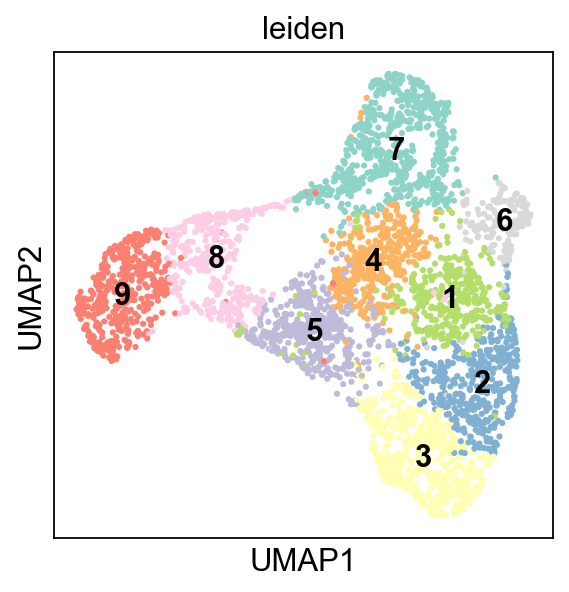

In [82]:
sc.pl.umap(adata,color="leiden",legend_loc="on data")

In [83]:
dct=dict(zip(adata.obs.leiden.cat.categories,adata.uns["leiden_colors"]))

In [84]:
adata.obs.leiden=adata.obs.leiden.cat.reorder_categories(np.arange(1,10).astype(str))
newpalette=[dct[l] for l in adata.obs.leiden.cat.categories]

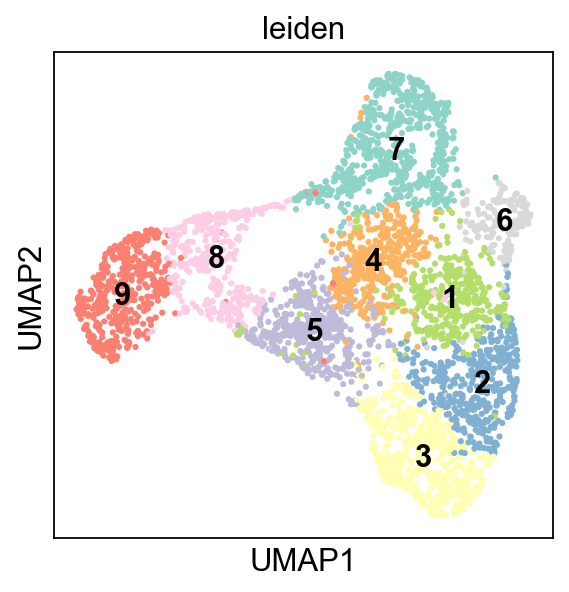

In [85]:
sc.pl.umap(adata,color="leiden",legend_loc="on data",palette=newpalette)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1534.47it/s]


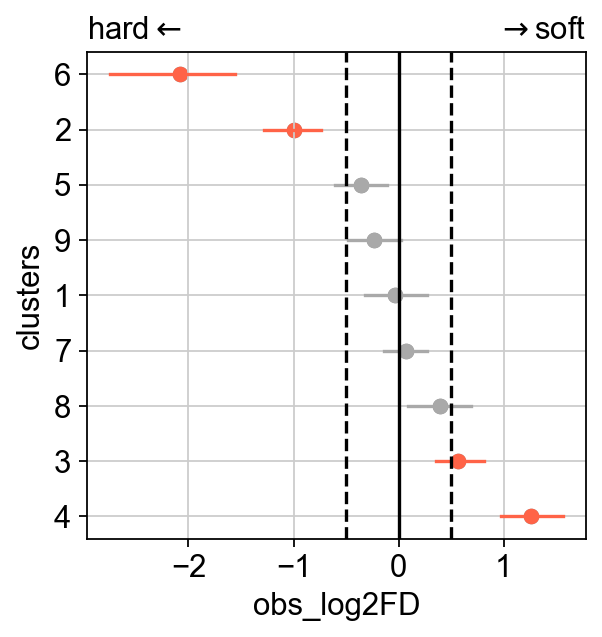

In [86]:
prop_res = proportion_test.proportion_test(adata,"condition","leiden","hard","soft",
            n_permutations=1000,n_jobs=10,log2FD_cutoff=.5)
proportion_test.plot_proportion_test(prop_res,show_legend=False)

In [87]:
counts_by_leiden=dict(zip(adata.obs.leiden.cat.categories,
         [adata[adata.obs.leiden==l].X.T.A for l in adata.obs.leiden.cat.categories]))

In [88]:
psis=np.array(adata_bulk.X.T)

In [90]:
from rnasieve.preprocessing import model_from_raw_counts
model, cleaned_psis = model_from_raw_counts(counts_by_leiden, psis)

In [91]:
res=model.predict(cleaned_psis)
res.index=adata_bulk.obs_names

In [92]:
conf=model.compute_marginal_confidence_intervals(sig=0.05)
err=np.array([[np.diff([i,j])[0] for i,j in c] for c in conf]).ravel()

In [93]:
toplot=res.loc[res.index.str.startswith("D0")].reset_index().melt(id_vars="index")
toplot["cond"]=[s[1] for s in toplot["index"].str.split("_")]
toplot.variable=toplot.variable.astype("category").cat.reorder_categories(prop_res.sort_values("obs_log2FD").index.tolist())

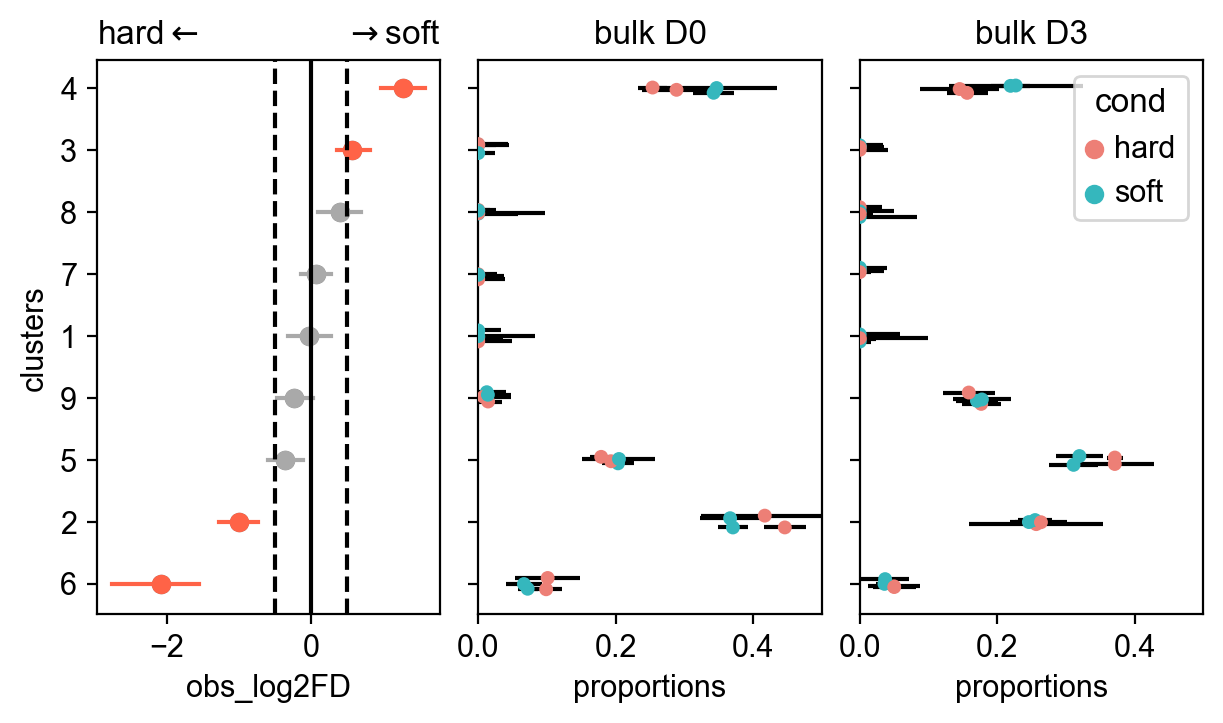

In [94]:
import seaborn as sns
sc.set_figure_params()
scv.set_figure_params()
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(6,3.5),constrained_layout=True)
proportion_test.plot_proportion_test(prop_res,show_legend=False,ax=ax1)

toplot=res.loc[res.index.str.startswith("D0")].reset_index().melt(id_vars="index")
toplot["cond"]=[s[1] for s in toplot["index"].str.split("_")]
neworder=prop_res.sort_values("obs_log2FD").index.tolist()
neworder.reverse()
toplot.variable=toplot.variable.astype("category").cat.reorder_categories(neworder)

sns.stripplot(y="variable",x="value",hue="cond",palette=["#ED7F76","#35B7BD"],data=toplot,ax=ax2)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax2.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
        
ax2.errorbar(x_coords, y_coords, xerr=err[:36],
    ecolor="k", fmt=' ', zorder=-1)

ax2.set_xlim([0,0.5])
ax2.set(ylabel=None)
ax2.set_title("bulk D0")
ax2.set_xlabel("proportions")
ax2.get_legend().remove()

toplot=res.loc[res.index.str.startswith("D3")].reset_index().melt(id_vars="index")
toplot["cond"]=[s[1] for s in toplot["index"].str.split("_")]
neworder=prop_res.sort_values("obs_log2FD").index.tolist()
neworder.reverse()
toplot.variable=toplot.variable.astype("category").cat.reorder_categories(neworder)
sns.stripplot(y="variable",x="value",hue="cond",palette=["#ED7F76","#35B7BD"],data=toplot,ax=ax3)

# Find the x,y coordinates for each point
x_coords = []
y_coords = []
for point_pair in ax3.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
        
ax3.errorbar(x_coords, y_coords, xerr=err[36:],
    ecolor="k", fmt=' ', zorder=-1)

ax3.set_xlim([0,0.5])
ax3.set(ylabel=None)
ax3.set_title("bulk D3")
ax3.set_xlabel("proportions")
plt.savefig("prop_overall.pdf")

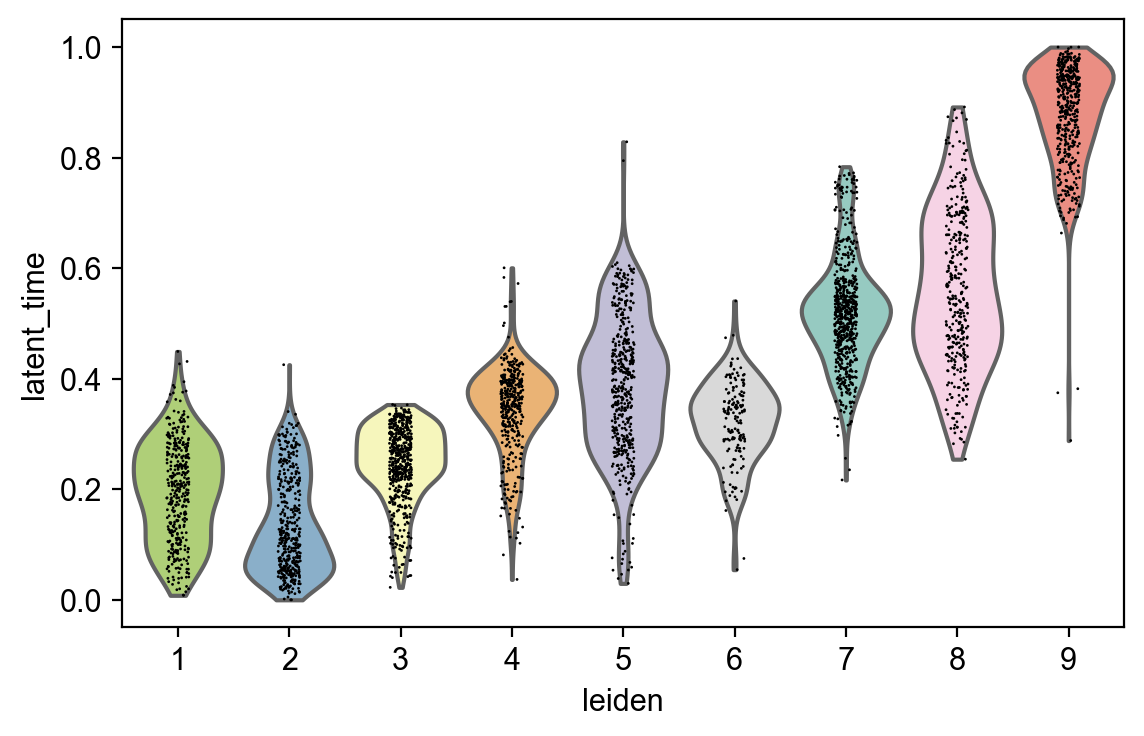

In [47]:
adata.obs["latent_time"]=0
adata.obs.loc[adata_hard.obs_names,"latent_time"]=adata_hard.obs["latent_time"]
adata.obs.loc[adata_soft.obs_names,"latent_time"]=adata_soft.obs["latent_time"]
sc.pl.violin(adata,"latent_time","leiden",save="leiden_vs_latentime.pdf")

In [48]:
sc.pp.calculate_qc_metrics(adata,log1p=None,percent_top=None,inplace=True)

In [49]:
adata.obs

,leiden,condition,latent_time,n_genes_by_counts,total_counts
hard_GTTAGACAGTAGCTCT-1,3,hard,0.135207,9861,154498.0
hard_GGTGGCTGTCGTCGGT-1,9,hard,0.980425,8913,133313.0
hard_CGTTAGACATTGACCA-1,4,hard,0.305237,9623,123200.0
hard_CTGCAGGCACTTGAGT-1,2,hard,0.149427,8916,111043.0
hard_CTGGACGTCTGGCTGG-1,4,hard,0.196142,9173,110716.0
...,...,...,...,...,...
soft_ACTTAGGTCAGACCTA-1,4,soft,0.350096,1025,1541.0
soft_TTGGGATCACGGCTAC-1,5,soft,0.242486,1083,1521.0
soft_GAGGCCTGTCGAATGG-1,7,soft,0.479711,986,1483.0
soft_AAGCGTTAGGGCAGTT-1,9,soft,0.288127,980,1417.0
